In [135]:
import pandas as pd
import sklearn as sk
from sklearn import linear_model
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import defaultdict
import datetime
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from random import random
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy import stats

#set pwd
dirpath = os.getcwd()
print("current directory is : " + dirpath)
foldername = os.path.basename(dirpath)
print("Directory name is : " + foldername)

current directory is : C:\Users\D4rkmatter\Documents\GitHub\insurance-claim-forecast
Directory name is : insurance-claim-forecast


<h2>Import and Simple Exploration</h2>

In [2]:
#Import

pet_data = pd.read_csv(dirpath+'/petdata.csv')
claim_data = pd.read_csv(dirpath+'/claimdata.csv')

In [3]:
#Take a look

print('Pet Data')
pet_data.head()
pet_data.info()
print('\n')
print('Claim Data')
claim_data.head()
claim_data.info()


Pet Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
PetId          10000 non-null int64
EnrollDate     10000 non-null object
CancelDate     4879 non-null object
Species        10000 non-null object
Breed          10000 non-null object
AgeAtEnroll    10000 non-null object
dtypes: int64(1), object(5)
memory usage: 468.9+ KB


Claim Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37049 entries, 0 to 37048
Data columns (total 4 columns):
ClaimId        37049 non-null int64
PetId          37049 non-null int64
ClaimDate      37049 non-null object
ClaimAmount    37049 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.1+ MB


In [5]:
#Join the dataframes

master_df = pet_data.join(claim_data.set_index('PetId'))
master_df.head()
#df.info()

,PetId,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,ClaimId,ClaimDate,ClaimAmount
0,0,2015-08-11,2018-07-13,Dog,Mixed Breed,5 years old,NaN,NaN,NaN
1,1,2014-02-15,2016-01-25,Cat,Mixed Breed,3 years old,NaN,NaN,NaN
2,2,2014-12-20,NaN,Dog,French Bulldog,8 weeks to 12 months old,7633.0,2018-02-14,82.80
2,2,2014-12-20,NaN,Dog,French Bulldog,8 weeks to 12 months old,13987.0,2018-08-07,190.69
2,2,2014-12-20,NaN,Dog,French Bulldog,8 weeks to 12 months old,24729.0,2018-04-14,346.61


<h2>Unfiltered Dataset Preliminary Correlation with ClaimAmount</h2>

In [6]:
def corr_helper(df):
    #correlation mapping helper function
    correlations = {}
    columns = ['Species','Breed','AgeAtEnroll']
    for column in columns:
        correlations[column] = df[column].str.get_dummies().corrwith(df.ClaimAmount)
        print(column,'Correlations \n',correlations[column],'\n')
        
corr_helper(master_df)

#NOTE
#To improve, bin the enroll dates and look for correlation.


Species Correlations 
 Cat   -0.012385
Dog    0.012385
dtype: float64 

Breed Correlations 
 Chihuahua           0.012405
French Bulldog      0.025846
Golden Retriever   -0.010085
Great Dane         -0.010346
Mixed Breed        -0.007777
Ragdoll             0.000994
dtype: float64 

AgeAtEnroll Correlations 
 0-7 weeks old               0.002432
1 year old                  0.006677
10 years old               -0.002107
11 years old                0.003204
12 years old               -0.016302
13 years old               -0.012579
2 years old                 0.001918
3 years old                 0.004914
4 years old                 0.022102
5 years old                 0.014092
6 years old                -0.009430
7 years old                 0.002772
8 weeks to 12 months old   -0.019357
8 years old                 0.014128
9 years old                 0.004504
dtype: float64 



<h1>Little to No Data (few_claims)</h1>

<h2>Data Cleaning and Reorganize</h2>
<p>Only include accounts that are 'active' meaning CancelDate is NaN <br>
    May overlook accounts which have cancelled in June but their service terminates in July? <br>
    No point in prediction claims for inactive accounts..</p>
<p>Histogram of active account claim occurances <br>
Put the accounts with less than 5 claims in a dataframe for feature engineering and exploration</p>

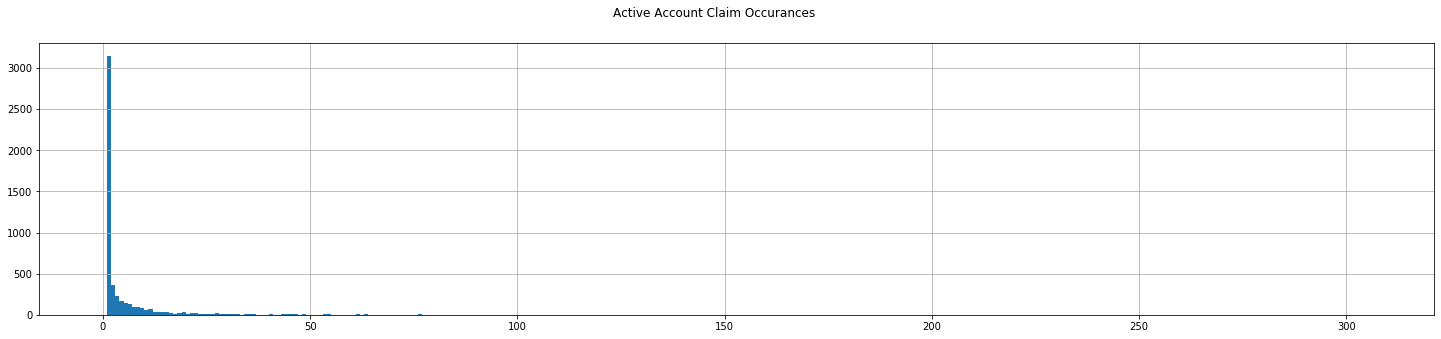

In [7]:
#Select Active Accounts
master_df.CancelDate = master_df.CancelDate.astype(str)
active = master_df.query('CancelDate == "nan"')

#Count occurences Pet_Id Claims
occurence = active['PetId'].value_counts(ascending=True)

#Occurence Histogram
occurence.hist(range=(0,occurence.max()),bins=occurence.max(),figsize=(25,5))
plt.suptitle('Active Account Claim Occurances')

occurence.describe()
#NOTE: Heavily Skewed less than 5 occurences

#create df for active accounts with less than 5 claims
occ_df= pd.DataFrame(occurence).reset_index()
occ_df.columns=['PetId','Count']




<h2>Split Data into sets with or without 3 or more historical data points</h2>

In [133]:
few_claims = occ_df.query('Count <=3')
many_claims = occ_df.query('Count >=4')

#Rejoin few claims with claim data
few_claims_df = few_claims.join(master_df, on='PetId', how='inner',rsuffix='_')
few_claims_df.sort_values(by='PetId')

many_claims_df = many_claims.join(master_df, on='PetId', how='inner',rsuffix='_')
many_claims_df.sort_values(by='PetId')

,PetId,Count,PetId_,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,ClaimId,ClaimDate,ClaimAmount
4690,2,14,2,2014-12-20,nan,Dog,French Bulldog,8 weeks to 12 months old,35617.0,2016-01-08,61.06
4690,2,14,2,2014-12-20,nan,Dog,French Bulldog,8 weeks to 12 months old,37156.0,2018-06-04,278.88
4690,2,14,2,2014-12-20,nan,Dog,French Bulldog,8 weeks to 12 months old,7633.0,2018-02-14,82.80
4690,2,14,2,2014-12-20,nan,Dog,French Bulldog,8 weeks to 12 months old,13987.0,2018-08-07,190.69
4690,2,14,2,2014-12-20,nan,Dog,French Bulldog,8 weeks to 12 months old,25317.0,2018-07-14,27.25
...,...,...,...,...,...,...,...,...,...,...,...
4354,9998,8,9998,2015-11-15,nan,Cat,Mixed Breed,8 weeks to 12 months old,26490.0,2018-11-17,661.25
4354,9998,8,9998,2015-11-15,nan,Cat,Mixed Breed,8 weeks to 12 months old,12062.0,2016-12-26,5009.40
4354,9998,8,9998,2015-11-15,nan,Cat,Mixed Breed,8 weeks to 12 months old,11814.0,2016-12-20,382.12
4354,9998,8,9998,2015-11-15,nan,Cat,Mixed Breed,8 weeks to 12 months old,6869.0,2016-07-05,299.62


<h2>Categorical-Claim correlation and relationships</h2>
<p>Rational: <br>There is not enough claim data to do forecasting for this subset of PetId's <br>
    Thus, some heuristics will need to be employed to guestimate based upon categorical data and relationships <br><br>
I am looking for meaningful correlation between pet categorical information and ClaimAmount <br>
If no strong relationship can be established, a decision-tree-like method will be used to downselect to the median of a given class of classes <br>
e.g. median(Dog & Mixed Breed & 3 years old)</p>
<p><br>NOTE: This only applies to the subset of PetId's with claim counts less than 3 <br>
All others will use forecasting methods</p>

In [134]:
#look again at correlations with ClaimAmount
corr_helper(few_claims_df)

Species Correlations 
 Cat   -0.002543
Dog    0.002543
dtype: float64 

Breed Correlations 
 Chihuahua          -0.005961
French Bulldog      0.009440
Golden Retriever    0.004891
Great Dane          0.016600
Mixed Breed        -0.027699
Ragdoll             0.085601
dtype: float64 

AgeAtEnroll Correlations 
 0-7 weeks old               0.002607
1 year old                  0.003937
10 years old                0.013124
11 years old               -0.010934
12 years old               -0.011236
13 years old                0.007742
2 years old                 0.002249
3 years old                 0.014027
4 years old                -0.007689
5 years old                 0.021010
6 years old                 0.010557
7 years old                -0.013632
8 weeks to 12 months old   -0.021355
8 years old                 0.042479
9 years old                -0.024394
dtype: float64 



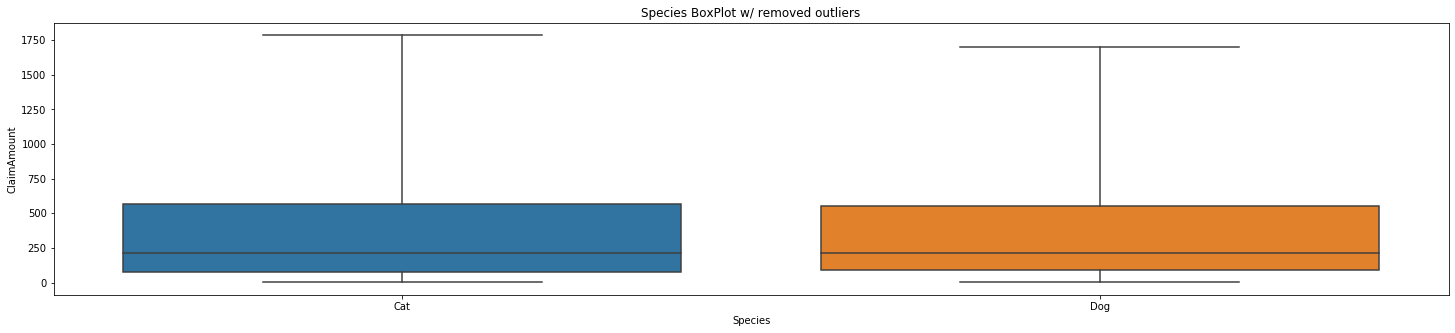

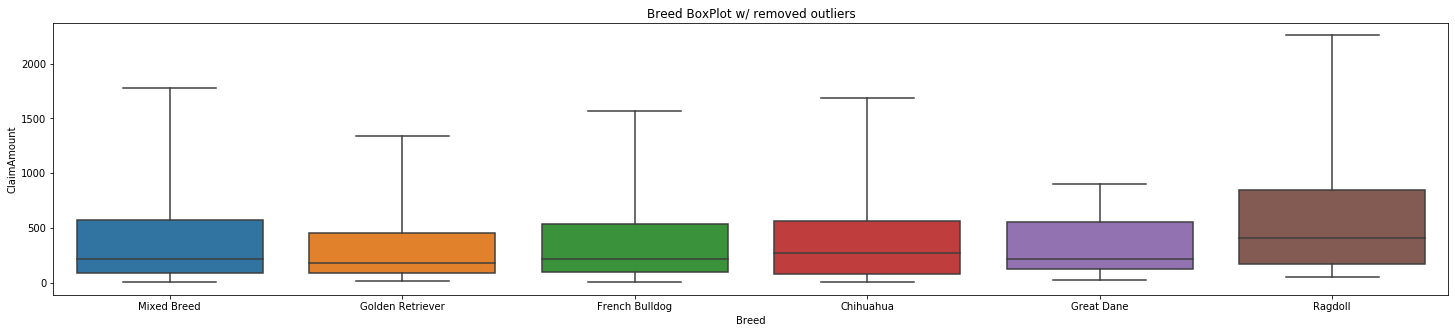

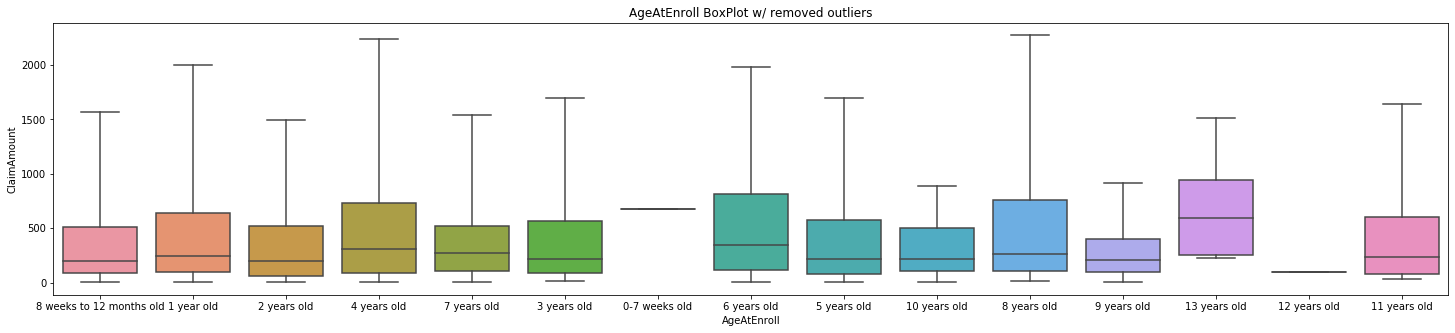

In [11]:
#NOTE
# Matplotlib uses 1.5*IQR as default to determine outliers to remove
# tested with 2.5
categories = ['Species','Breed','AgeAtEnroll']
for category in categories:
    plt.figure(figsize=(25,5))
    plt.title(category+' BoxPlot w/ removed outliers')
    sns.boxplot(x=few_claims_df[category],y=few_claims_df['ClaimAmount'],showfliers=False, whis=2.5)

<h2>few_claims predicted value lookup table</h2>
<p>Correlation does not exist in a meaningful manner</p>

<p><br> Build lookup table for union of categories and resultant median ClaimAmount value <br>
e.g. median(Dog & Mixed breed & 3 years old</p>

In [136]:


species_set = ['Dog','Cat']
age_set = master_df['AgeAtEnroll'].unique()
breed_set = master_df['Breed'].unique()


#Sloppy and Slow but it gets the job done for small datasets

nested_dict = lambda: defaultdict(nested_dict)
stats_lookup = nested_dict()

for species in species_set:
    for breed in breed_set:
        for age in age_set:
            
            #Query and frame it
            query_string = 'Species == "{}" & Breed == "{}" & AgeAtEnroll == "{}"'.format(species,breed,age)
            subset = master_df.query(query_string)
            subset = subset['ClaimAmount']
            
            #Nested dictionary for lookup
            stats_lookup[species][breed][age] = {'mean':subset.mean(),'median':subset.median(),
                                                 '1st_quantile':subset.quantile(.25),'2nd_quantile':subset.quantile(.75),
                                                'max':subset.max(),'min':subset.min()}
            

stats_lookup_df = pd.DataFrame.from_dict(stats_lookup)    
stats_lookup_df[0:10]
stats_lookup['Dog']['French Bulldog']['5 years old']


{'mean': 588.2666666666668,
 'median': 252.42,
 '1st_quantile': 206.70999999999998,
 '2nd_quantile': 801.9000000000001,
 'max': 1351.38,
 'min': 161.0}

<h2>Few number of claims heuristic predictions</h2>

In [180]:

few_preds = []
for _,pet in few_claims_df.iterrows():
    #print(pet['PetId'])
    #mean = stats_lookup[pet['Species']][pet['Breed']][pet['AgeAtEnroll']]['mean'].round(2)
    median = stats_lookup[pet['Species']][pet['Breed']][pet['AgeAtEnroll']]['median'].round(2)
    few_preds.append([pet['PetId'],median])

    

In [183]:
few_preds_df = pd.DataFrame(few_preds, columns=['PetId','prediction'])
few_preds_df.to_csv('few_predictions.csv')

In [179]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10003 entries, 0 to a
Data columns (total 2 columns):
PetId          10003 non-null object
predictions    10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 554.4+ KB


#NOTE
Need to compare median of a given PetID's class to it's actual previous value(s)
Will show if we're being crazy to guess median of class as opposed to previous data

<h1>Enough data for forecasting (many_claims)</h1>

In [69]:
many_claims_df

,PetId,Count,PetId_,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,ClaimId,ClaimDate,ClaimAmount
4058,5623,6,5623,2017-03-31,nan,Dog,Chihuahua,4 years old,7465.0,2018-02-09,8456.44
4058,5623,6,5623,2017-03-31,nan,Dog,Chihuahua,4 years old,7477.0,2018-02-08,6622.59
4058,5623,6,5623,2017-03-31,nan,Dog,Chihuahua,4 years old,21207.0,2017-05-22,211.40
4058,5623,6,5623,2017-03-31,nan,Dog,Chihuahua,4 years old,31772.0,2017-09-26,146.12
4058,5623,6,5623,2017-03-31,nan,Dog,Chihuahua,4 years old,31782.0,2017-09-27,3691.47
...,...,...,...,...,...,...,...,...,...,...,...
5120,3957,306,3957,2013-02-05,nan,Dog,Golden Retriever,8 weeks to 12 months old,40320.0,2016-07-28,67.83
5120,3957,306,3957,2013-02-05,nan,Dog,Golden Retriever,8 weeks to 12 months old,40327.0,2016-01-02,34.49
5120,3957,306,3957,2013-02-05,nan,Dog,Golden Retriever,8 weeks to 12 months old,40328.0,2018-05-31,124.15
5120,3957,306,3957,2013-02-05,nan,Dog,Golden Retriever,8 weeks to 12 months old,40386.0,2016-08-29,63.77


In [141]:
#look again at correlations with ClaimAmount
corr_helper(many_claims_df)

Species Correlations 
 Cat   -0.011358
Dog    0.011358
dtype: float64 

Breed Correlations 
 Chihuahua           0.029998
French Bulldog      0.033439
Golden Retriever   -0.024070
Great Dane         -0.012886
Mixed Breed        -0.008163
Ragdoll            -0.007405
dtype: float64 

AgeAtEnroll Correlations 
 1 year old                  0.013127
10 years old               -0.003344
11 years old                0.014465
12 years old               -0.018457
13 years old               -0.012884
2 years old                 0.007760
3 years old                -0.007711
4 years old                 0.023881
5 years old                 0.025932
6 years old                -0.019800
7 years old                -0.019623
8 weeks to 12 months old   -0.009950
8 years old                 0.002845
9 years old                -0.005874
dtype: float64 



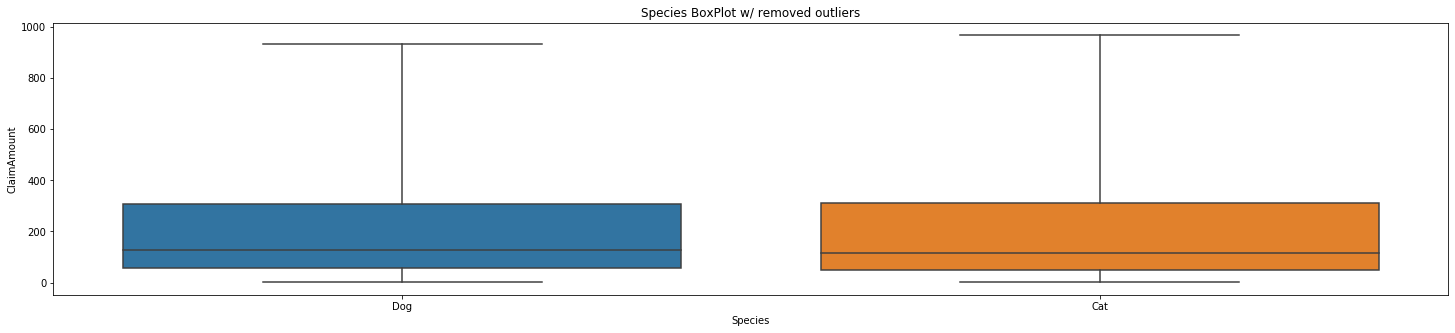

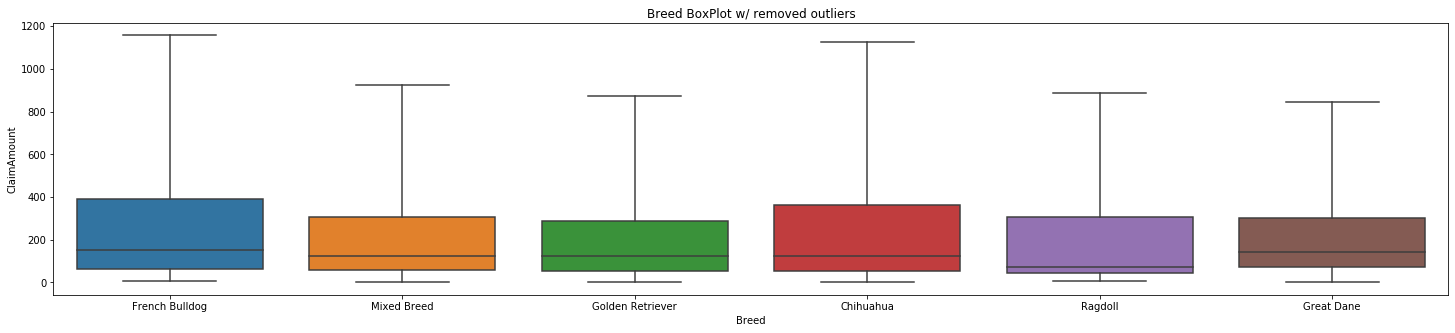

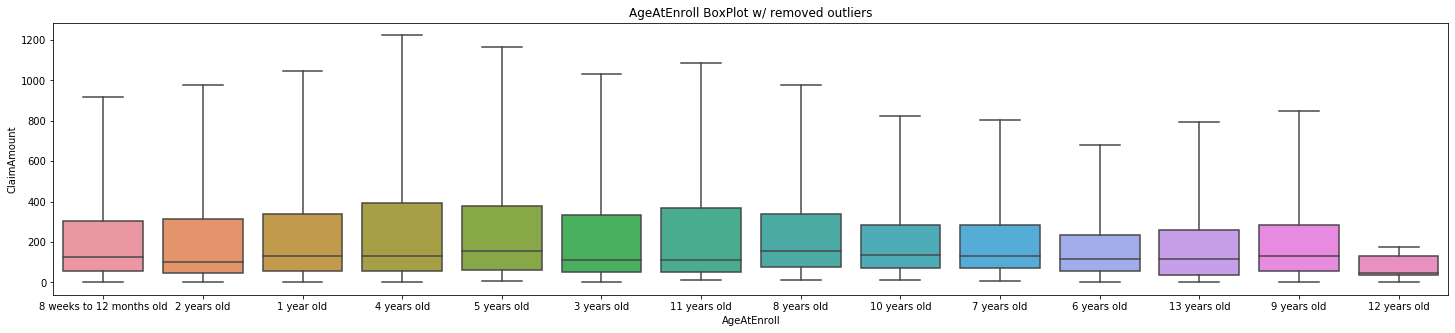

In [142]:
#NOTE
# Matplotlib uses 1.5*IQR as default to determine outliers to remove
# tested with 2.5
categories = ['Species','Breed','AgeAtEnroll']
for category in categories:
    plt.figure(figsize=(25,5))
    plt.title(category+' BoxPlot w/ removed outliers')
    sns.boxplot(x=many_claims_df[category],y=many_claims_df['ClaimAmount'],showfliers=False, whis=2.5)

In [118]:
test_many_std = many_clean_df[['ClaimAmount','EnrollDate_delta','ClaimDate_delta']]


threshold = 3
z = np.abs(stats.zscore(test_many_std))


In [99]:
test_many_std

,ClaimAmount,EnrollDate_delta,ClaimDate_delta
4058,8456,88,96
4058,6622,88,96
4058,211,88,87
4058,146,88,91
4058,3691,88,91
...,...,...,...
5120,67,38,77
5120,34,38,71
5120,124,38,100
5120,63,38,79


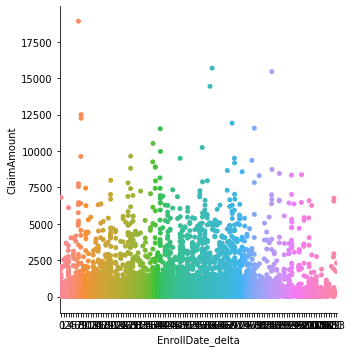

In [108]:

sns.catplot(x="EnrollDate_delta",y="ClaimAmount",data=test_many_std)

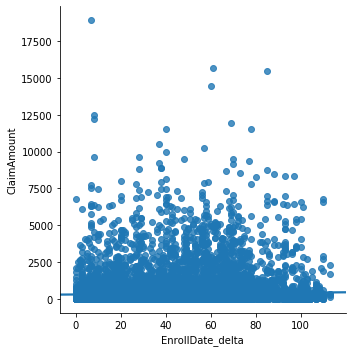

In [109]:

sns.lmplot(x="EnrollDate_delta",y="ClaimAmount",data=test_many_std)

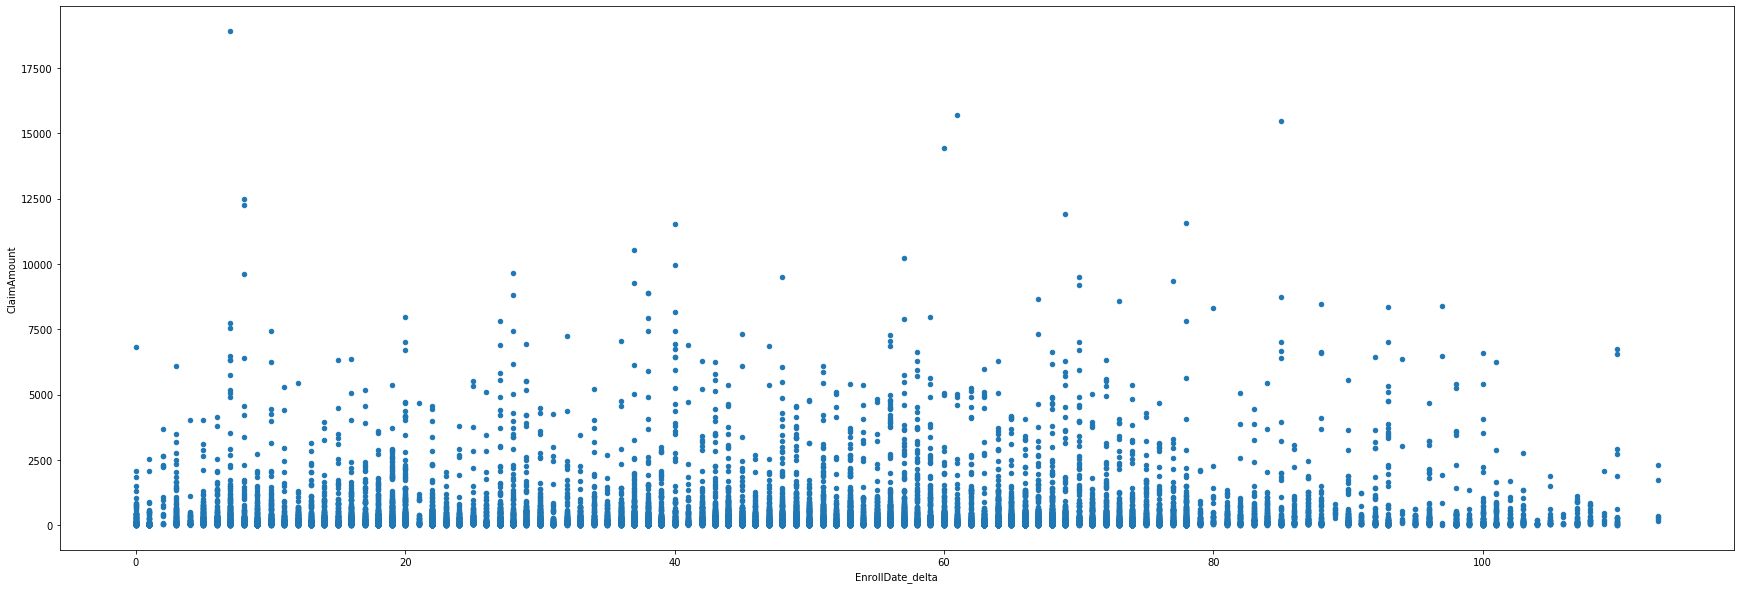

In [110]:


test_many_std = test_many_std.sort_values(by="EnrollDate_delta")
test_many_std.plot.scatter(x='EnrollDate_delta',y='ClaimAmount',figsize=(30,10))

In [ ]:
test_many_std.set_index('ClaimAmount')

<h2>Check AutoCorrelation</h2>

In [79]:
#check correlation
many_clean_df['EnrollDate_delta'].corr(many_clean_df['ClaimAmount'])

many_clean_df['ClaimDate_delta'].corr(many_clean_df['ClaimAmount'])

0.024745924189777422

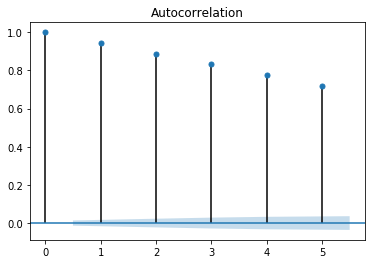

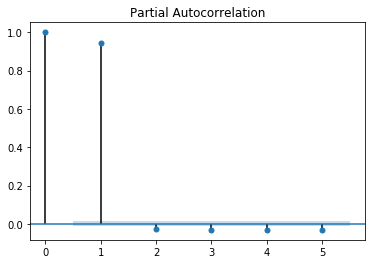

In [130]:

plot_acf(test_many_std['EnrollDate_delta'],lags=5)
plot_pacf(test_many_std['EnrollDate_delta'],lags=5)
plt.show()

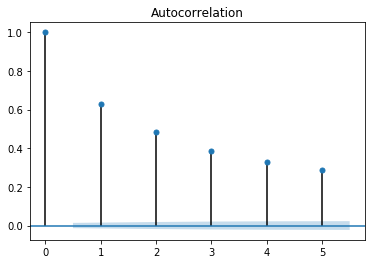

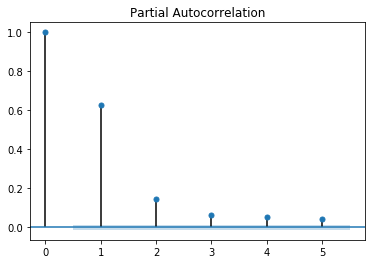

In [131]:
plot_acf(test_many_std['ClaimDate_delta'],lags=5)
plot_pacf(test_many_std['ClaimDate_delta'],lags=5)
plt.show()

<h2>Forecast Many Data Points</h2>

In [215]:
test

,ClaimDate_delta,EnrollDate_delta,Cat,Dog,Chihuahua,French Bulldog,Golden Retriever,Great Dane,Mixed Breed,Ragdoll,...,13 years old,2 years old,3 years old,4 years old,5 years old,6 years old,7 years old,8 weeks to 12 months old,8 years old,9 years old
0,96,88,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,96,88,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,87,88,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,91,88,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,91,88,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20622,77,38,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20623,71,38,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20624,100,38,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20625,79,38,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [226]:
many_claims_df.query('Count ==306')

,PetId,Count,PetId_,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,ClaimId,ClaimDate,ClaimAmount
5120,3957,306,3957,2013-02-05,nan,Dog,Golden Retriever,8 weeks to 12 months old,217.0,2016-12-24,64.40
5120,3957,306,3957,2013-02-05,nan,Dog,Golden Retriever,8 weeks to 12 months old,218.0,2016-12-22,116.15
5120,3957,306,3957,2013-02-05,nan,Dog,Golden Retriever,8 weeks to 12 months old,776.0,2015-12-31,175.95
5120,3957,306,3957,2013-02-05,nan,Dog,Golden Retriever,8 weeks to 12 months old,777.0,2015-12-09,172.20
5120,3957,306,3957,2013-02-05,nan,Dog,Golden Retriever,8 weeks to 12 months old,778.0,2015-11-26,64.40
...,...,...,...,...,...,...,...,...,...,...,...
5120,3957,306,3957,2013-02-05,nan,Dog,Golden Retriever,8 weeks to 12 months old,40320.0,2016-07-28,67.83
5120,3957,306,3957,2013-02-05,nan,Dog,Golden Retriever,8 weeks to 12 months old,40327.0,2016-01-02,34.49
5120,3957,306,3957,2013-02-05,nan,Dog,Golden Retriever,8 weeks to 12 months old,40328.0,2018-05-31,124.15
5120,3957,306,3957,2013-02-05,nan,Dog,Golden Retriever,8 weeks to 12 months old,40386.0,2016-08-29,63.77


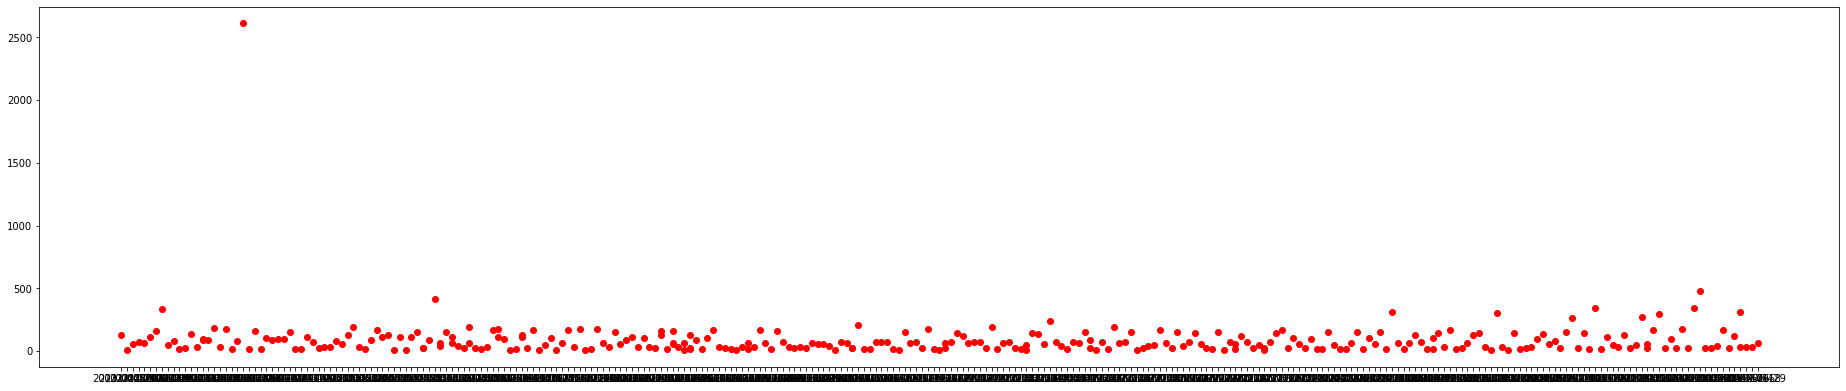

In [232]:
test = many_claims_df.query('PetId == 3957')
test = test.sort_values(by='ClaimDate')

#ax = sns.scatterplot(x=test.ClaimDate, y=test.ClaimAmount)
fig=plt.figure(figsize=(25,5))
ax=fig.add_axes([0,0,1,1])
ax.scatter(test.ClaimDate, test.ClaimAmount, color='r')

plt.show()

#sns.regplot(test.ClaimDate, test.ClaimAmount)


In [246]:
many_clean = pd.read_csv('many_clean_data.csv')
test = many_clean.query('PetId ==3957')
test = test.sort_values(by='ClaimDate_delta')
test = test.drop(test.columns[0],axis='columns')
test = test.drop(test.columns[0],axis='columns')
y = test.ClaimAmount
test = test.drop('ClaimAmount', axis='columns')
X = test[['ClaimDate_delta']]
y

20412      7
20411    127
20330     55
20344     70
20346    112
        ... 
20337    308
20611     33
20469     32
20470     32
20517     62
Name: ClaimAmount, Length: 306, dtype: int64

In [239]:
test

,ClaimDate_delta,EnrollDate_delta,Cat,Dog,Chihuahua,French Bulldog,Golden Retriever,Great Dane,Mixed Breed,Ragdoll,...,13 years old,2 years old,3 years old,4 years old,5 years old,6 years old,7 years old,8 weeks to 12 months old,8 years old,9 years old
20412,38,38,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20411,38,38,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20330,39,38,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20344,45,38,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20346,46,38,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20337,111,38,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20611,111,38,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20469,111,38,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20470,112,38,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [242]:
import statsmodels.api as sm


# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            ClaimAmount   R-squared (uncentered):                   0.203
Model:                            OLS   Adj. R-squared (uncentered):              0.200
Method:                 Least Squares   F-statistic:                              77.50
Date:                Tue, 21 Jan 2020   Prob (F-statistic):                    1.01e-16
Time:                        21:45:02   Log-Likelihood:                         -1995.1
No. Observations:                 306   AIC:                                      3992.
Df Residuals:                     305   BIC:                                      3996.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
ClaimDate_delta     0.9996      0.114      8.804      0.000       0.776       1.223
==============================================================================
Omnibus:                      604.979   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           463607.549
Skew:                          12.439   Prob(JB):                         0.00
Kurtosis:                     192.057   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score





# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes_y[:-20]
diabetes_y_test = diabetes_y[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(diabetes_y_test, diabetes_y_pred))

In [241]:
petids = many_clean_df['PetId'].unique()
pet_pred = {}
july = 106
for pet in petids:
    holder = many_clean_df.query('PetId == {}'.format(pet))
    holder.sort_values(by='ClaimDate_delta')
    y = holder.ClaimAmount.values
    X = holder.ClaimDate_delta.values.reshape(-1,1)
    
    reg = sk.linear_model.LinearRegression().fit(X,y)
    pet_pred[pet]=reg.predict(july)
    
    fig=plt.figure(figsize=(25,5))
    ax=fig.add_axes([0,0,1,1])
    ax.scatter(holder.ClaimDate_delta, test.ClaimAmount, color='r')

    plt.show()

    count+=1
    if count ==10:
        break
    

ValueError: Expected 2D array, got scalar array instead:
array=106.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [279]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from scipy import stats

#std_dev = 3
#many_clean_df = many_clean_df[(np.abs(stats.zscore(many_clean_df)) < float(std_dev)).all(axis=1)]

#simple linear regression
y = pd.DataFrame(many_clean_df['ClaimAmount'])
X = pd.DataFrame(many_clean_df['ClaimDate_delta'])

lm = linear_model.LinearRegression()
model = lm.fit(X,y)



In [280]:
lm.score(X,y)

0.0006123607640060591

<h2>Forecast Test</h2>

<h2>Main Loop</h2>
<p>Per PetId, run forecast models <br>
predict for t(july) <br>
save results in dictionary per PetId</p>

In [424]:
pet_ids = many_claims_df['PetId'].unique()
len(pet_ids)

for pet_id in pet_ids:
    
    subset = many_claims_df.query('PetId == {}'.format(pet_id))
    subset.sort_values(by='ClaimDate')
    x = subset.ClaimDate
    y = ClaimAmount
    

1063

<h2>Forecasting Ensamble</h2>
<p>Autoregression <br> Multi-linear regression <br> ARIMA <br>HW Exponential Smoothing</p>

In [247]:
claim_1d = many_clean[['ClaimDate_delta','ClaimAmount']].set_index('ClaimDate_delta')
claim_1d

,ClaimAmount
ClaimDate_delta,
96,8456
96,6622
87,211
91,146
91,3691
...,...
77,67
71,34
100,124


In [ ]:

# AR example
from statsmodels.tsa.ar_model import AR
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
model = AR(claim_1d)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data))

print(yhat)

In [ ]:
y = [x + random() for x in range(1, 100)]
x = [x for x in range(1,100)]
data= [x + random() for x in range(1, 100)]
# fit model
model = ARIMA(data, order=(1, 1, 1))
model_fit = model.fit(disp=True)
# make prediction
yhat = model_fit.predict(99, typ='levels')
print(yhat)

In [50]:
input_df =claim_data.sort_values(by='PetId')
input_df.info()
for index,row in input_df.iterrows():
    print(row['PetId'], row[''])


<class 'pandas.core.frame.DataFrame'>
Int64Index: 37049 entries, 24463 to 11428
Data columns (total 4 columns):
ClaimId        37049 non-null int64
PetId          37049 non-null int64
ClaimDate      37049 non-null object
ClaimAmount    37049 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.4+ MB
